In [2]:
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion

import json
import numpy as np
import cv2

### Explore Data

In [2]:
# Create soft links

!ln -s /media/juancr/Data/Lyft/train_images images
!ln -s /media/juancr/Data/Lyft/train_maps maps
!ln -s /media/juancr/Data/Lyft/train_lidar lidar

In [2]:

with open('/media/juancr/Data/Lyft/train_data/sample_data.json') as json_file:
    data = json.load(json_file)


lyft_data = LyftDataset(data_path='.', json_path='/media/juancr/Data/Lyft/train_data', verbose=True)

lyft_data.list_scenes()

first_scene = lyft_data.scene[0]

sample_token = first_scene['first_sample_token']

lyft_data.render_sample(sample_token)

second_scene = lyft_data.scene[1]

sample_second_token = second_scene['first_sample_token']

lyft_data.render_sample(sample_second_token)

lyft_data.instance[100]

instance_token = lyft_data.instance[100]

lyft_data.render_instance(instance_token['token'])

lyft_data.list_categories()

### LyftTestDataset Class

In [3]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        # Initialize map mask for each map record.
        for map_record in self.map:
            map_record["mask"] = MapMask(self.data_path / map_record["filename"], resolution=map_resolution)

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        # Add reverse indices from log records to map records.
        if "log_tokens" not in self.map[0].keys():
            raise Exception("Error: log_tokens not in map table. This code is not compatible with the teaser dataset.")
        log_to_map = dict()
        for map_record in self.map:
            for log_token in map_record["log_tokens"]:
                log_to_map[log_token] = map_record["token"]
        for log_record in self.log:
            log_record["map_token"] = log_to_map[log_record["token"]]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

In [33]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

In [32]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [6]:
bev_shape = (336, 336, 3)
target_im = np.zeros(bev_shape, dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)


In [20]:
import pandas as pd

In [36]:
sample_sub = pd.read_csv('/media/juancr/Data/Lyft/sample_submission.csv')
sample_sub.head()

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,NaN
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,NaN
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,NaN


In [31]:
#sample_sub = pd.read_csv('/media/juancr/Data/Lyft/sample_submission.csv')
#sample_sub.head()

sample_data_train = pd.read_json('/media/juancr/Data/Lyft/train_data/sample_data.json')

In [36]:
sample_data_train.head()

,is_key_frame,prev,fileformat,token,timestamp,next,ego_pose_token,sample_token,filename,calibrated_sensor_token,width,height
0,True,d190078ec7869ad5c9e5417371aa3b45eb1c22804a0a29...,bin,ad87e1763749cc8562cca68e2046db128185c80c3e7599...,2019-02-11 21:36:23.701948250,8182fb6868baf63c245a4994b7f3034a7d281d1928a784...,d90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeae...,fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced3...,lidar/host-a007_lidar1_1233956183701948366.bin,3b463530b5bae9698c9cc803c1731c36abd359a7296e23...,NaN,NaN
1,True,83f6f61cb6f2fc9b985cc23bd5613219eee7da390cd083...,bin,ea079138d89f3887b2bfcddfe16b747e2ec7a366ce66b3...,2019-03-04 23:27:01.601281500,c291c5e9c1c70363496e304e964a33036cace6d14c177e...,97c348ec54ca0cfc892361595513d34d19e53583f97832...,c60dc70e93949cbefdda68813cf024fe8e9103bc8a68d6...,lidar/host-a008_lidar1_1235777221601281486.bin,2dba2d3171d7c60b847d65d96babfd7efb487428fa5a3c...,NaN,NaN
2,True,44555daed204fea486ec10ea1747432501b9f06fe93041...,jpeg,454c65ee6c297d64b17852b4c56def9781a84dcb8558a8...,2019-02-20 23:24:24.650905000,d4b751751ca5424375d0faf3d22b9af83e7c84e1598ba0...,dce9c81e168db4f6fa442cc0bd484a4926dfe73946ba59...,254cea140f7d14fc86e73f789794fb73f81c05831d40f3...,images/host-a007_cam6_1234740264650905006.jpeg,30fcfa36375c0d36fce508cd04c9b1dd07ac283eb87352...,2048.0,864.0
3,True,de75f3f347742035f2442f4a5fa0334946642daa2d07d8...,jpeg,779018e1f92debcf5c5c28e9577677c6595679780bdf9b...,2019-01-07 22:44:02.299360000,4796998aae092f295fe4f96ce57fc673e3292c7b0368ac...,bb93bbeb3b6d151c805729dba52d4c0c0070f20376090b...,810503d8ca51e9692021ecb56e2b2f2098beaf396cd207...,images/host-a007_cam3_1230936242299360006.jpeg,76e7bb72dd96cb18f5c75abae3b5bab5e41bd4aac39445...,1224.0,1024.0
4,True,a208568472ef6719faa2540622ada30b004583de9153f4...,jpeg,d966960819eb0aca2883cd3c8d8c5e2540bda952a8cada...,2019-02-08 18:20:23.917652000,1a82a24dafde93234579ae59f48498a8436361cc641a64...,53f6821330f6bc07603db70fde1a96b25bd919471e923c...,119b8c4bbaf1493bebaaa7d823934a8a3f5a80fb095630...,images/host-a004_cam2_1233685223917652006.jpeg,aac6241dd5e28264de261422696af2037868c5133d9329...,1224.0,1024.0


In [33]:
sample_data_train.loc[sample_data_train.sample_token == sample_sub.loc[0,'Id']]

NameError: name 'sample_sub' is not defined

In [40]:
sample_data_train.token[0]

'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696'

In [47]:
from matplotlib import pyplot as plt

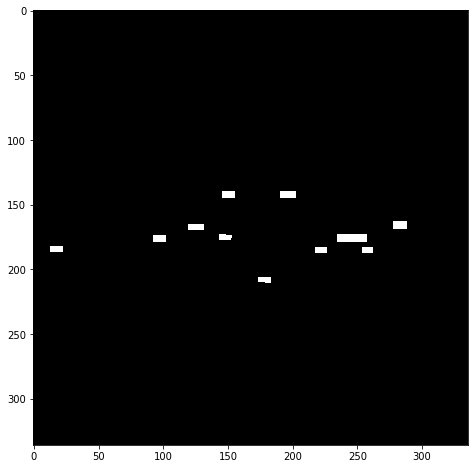

In [48]:
# token is lidar_token
sample_lidar_token = sample_data_train.token[0]
sample_ego_pose_token = sample_data_train.ego_pose_token[0]
num_classes = 9
ego_pose = level5data.get("ego_pose", sample_ego_pose_token)

boxes = level5data.get_boxes(sample_lidar_token)
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

###  Read Test data

In [44]:
sample_data_test = pd.read_json('/media/juancr/Data/Lyft/test_data/sample_data.json')

In [45]:
sample_data_test.head()

,fileformat,is_key_frame,height,timestamp,filename,token,ego_pose_token,sample_token,prev,next,calibrated_sensor_token,width
0,jpeg,True,1024.0,2019-02-08 19:23:28.717605000,images/host-a011_cam2_1233689008717605006.jpeg,1b7ad8ac352589c4a86f9a6cbef4f136a4272bd6291eae...,e170e300eb28df54eaf0ffc16659124aebd3d0df264e24...,2f7129731b7a7a81265deb5f8df44e937ea60824238a1b...,cba4c4e61f2b8824ed22e37e85cd3bf19e9f970eb4fb78...,7e83e9c889f6ef2b45da7223da3b4a201e87b1d88b9cab...,04afbdfff5bc7913179997e0a8e4067ca9eac5cf329001...,1224.0
1,bin,True,NaN,2019-02-11 23:17:58.301031250,lidar/host-a011_lidar1_1233962278301031366.bin,5468aea18ec7506b5660aab1d09a534d840eaa252b3545...,45ebc7b166fac45f97292939113bbef9b8cfd9cb267021...,311a858f719389a4fd914ccf6bb3b1294c10f95fbbe417...,7a7e5f25824c7db4a3e2ea5ca18eefa23bf2fc13e3549e...,548fd8ce4b103cf28bb2d8059716b05714b96f50919f65...,043947e092f2df7723186143caafad12b5f4ae51328ce0...,NaN
2,jpeg,True,1024.0,2019-02-11 21:55:58.850968000,images/host-a015_cam0_1233957358850968006.jpeg,59a7689c386ae985181f3b709c2ce3e67b666086be8142...,96f269f9d63e2827d883cebb6529dcfad8f44a59245bdf...,7bfdadbdae169b0dc4a9704de19654203d5658aa961e78...,37dca76ea52c5964eb4ebd8be96b09d6a461f03013a2c9...,758a1ca944111554b062a0df648c3d569df06ff8789ba6...,c6823615f781fb7fbc629fc6992a6dc15786fd3d613eaa...,1224.0
3,jpeg,True,864.0,2019-02-01 20:50:52.450948000,images/host-a004_cam6_1233089452450948006.jpeg,b87b3ea33a28bbd065fa7123dcc9ff71cac88f3b1d5754...,8d148e2defa6150444d41c1725e5e3a10b0763e04e883a...,85d428b83c90880a23aa634da1a821d0af6e1045046849...,4c291e1f5b4bb43f43b7e268be1efcef9b1c912903e336...,ad749dd7344f857720aaa9cc52b2714f942fd6fe5bc08d...,bb86c8ed87c60936572901c1d8159fcb6f9d46ec7e2ac2...,2048.0
4,jpeg,True,1024.0,2019-03-08 23:44:18.984485000,images/host-a011_cam4_1236123858984485006.jpeg,d1d674e496610b7c5d42ba46bc48d237b55c77627eec9a...,e6ed33615480148fb928303fda1a38d8074084a09a6b23...,24a7090eca5d85a680bd975ad30ad43bd2a598227fa697...,644f1c0b49b00c78e4ac38f138000e069a6c470fc92c01...,e04d87e2d13b65d62e3c8105004f447cf86164906a2a87...,1752d13cc27a84424457a0ec095f8b501342ae6b96dac7...,1224.0


In [47]:
sample_data_test.loc[sample_data_test.sample_token == sample_sub.loc[0,'Id']]

,fileformat,is_key_frame,height,timestamp,filename,token,ego_pose_token,sample_token,prev,next,calibrated_sensor_token,width
6697,jpeg,True,1024.0,2019-02-11 23:10:45.884485000,images/host-a011_cam4_1233961845884485006.jpeg,af733b3a1d5be2e80927abb56c02841580ba97a93a9ff5...,0d3996e371c01ba4661fa5c37fa15cf6c3ef329eddb7fb...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,eaf4e750e2c7a2227bc7a9eb76a504bc75dac284438206...,5b6f1091d3fb4ab9c0df9d4b72acad9eb2a4878ae725b2...,1752d13cc27a84424457a0ec095f8b501342ae6b96dac7...,1224.0
13841,jpeg,True,1024.0,2019-02-11 23:10:45.800995000,images/host-a011_cam3_1233961845800995006.jpeg,51dd917fb9a5971d77451e8961af5ccdaeb3bb220a4fab...,af41ecc96888d3984c6e2d548dac2d9a5998be443d1625...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,9b969d8e76872e77fc374d0906fd291494d69b3955f85a...,f916c7750f0f333e459191b5fb2a2c4edc1798bc8a738e...,5132cd2285771663c4a5066d0bed44901b87d57fdd97aa...,1224.0
93041,jpeg,True,1024.0,2019-02-11 23:10:45.867719000,images/host-a011_cam5_1233961845867719006.jpeg,cf6ebe722ef7e56470c9bdb7aa4b7b79cb6ba951d0ff2d...,77ef701fd88ac81440e1c7f2494e0e6f1dabc4bca4d46e...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,6914e74cc89da0394580254e8d37df9582c149c1133b39...,db5ac23561bbb98a83058989ac8f8241d96b98d23082aa...,4a1b6804918907b7944679c90319c9d595966a7b17fb2f...,1224.0
115439,jpeg,True,1024.0,2019-02-11 23:10:45.817605000,images/host-a011_cam2_1233961845817605006.jpeg,5efe8243df94dff3ea097cc9cebab2f3f3294fb6b254c6...,7bcf794a8b924b9ed45e3a52669cc72d527c3c097f6c15...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,8fdba1a32541d2111f40f865835b9981a8aefe68549f4b...,d6d991902ec8b092645870b376816436ed144da4f918db...,04afbdfff5bc7913179997e0a8e4067ca9eac5cf329001...,1224.0
132760,bin,True,NaN,2019-02-11 23:10:45.901454500,lidar/host-a011_lidar1_1233961845901454486.bin,84e7e211435d1721daa05e9bb352821ed66be21a2e5019...,61d098d9f185cfc4bfa5d1718bb1eb0c2ac77c93ed1d46...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,2eca61172e0ed55871e65b60de83f0b660f63e92481269...,deaaf93d0184ec6d915b32923ac027e489b16e489a6e27...,043947e092f2df7723186143caafad12b5f4ae51328ce0...,NaN
186492,jpeg,True,864.0,2019-02-11 23:10:45.851145000,images/host-a011_cam6_1233961845851145006.jpeg,c06a297ada8204c8a6c998ae64a5df2ab57174f64adc13...,86c339b4dea02017dafa2d45ed90e6fbe2b8cd77bf8b15...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,983389f329ddb08b7608efedfd729f46804da5480d4605...,64f2e12245a50aecd47afb7da605570efc31c833db315f...,06e8407200e185f3b0efc2f09dfa13af10ec955e01ad5b...,2048.0
188817,jpeg,True,1024.0,2019-02-11 23:10:45.834517000,images/host-a011_cam1_1233961845834517006.jpeg,d9f7955a5f864596aa2806d78c9986141764e6d8ac0222...,671ee9d6f209845301f593295c31481dfd43c67a0a1bfb...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,4d0dc7e0962fd7c4d67e8b06ac73d20f2b45b73f642d22...,75470c664e9c589f009a42b36bf0e7f8ebb06b36e3d100...,a873681e01d049e66e8a6833240dca37643bf10855dafc...,1224.0
194693,jpeg,True,1024.0,2019-02-11 23:10:45.851142000,images/host-a011_cam0_1233961845851142006.jpeg,23628ad51a713eabb69ec9f497e9914653bcc80a91b1d7...,b369d80c46f4c0f243566aafd037504d1a85a163381102...,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,3b32a672b0b3dd45ee09e817582ebcf7203c8cff3b67fa...,61a2c206b62c86391655a7c997a500358cae8f3a517dcb...,f82ed8f880ce9bc140e457f2a4c9b8c438bebbd99b76bc...,1224.0


In [29]:
level5data = LyftDataset(data_path='.', json_path='/media/juancr/Data/Lyft/train_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 6.8 seconds.
Reverse indexing ...
Done reverse indexing in 2.2 seconds.


sample_sub.loc[0,'Id']
level5data.get("sample", sample_token)

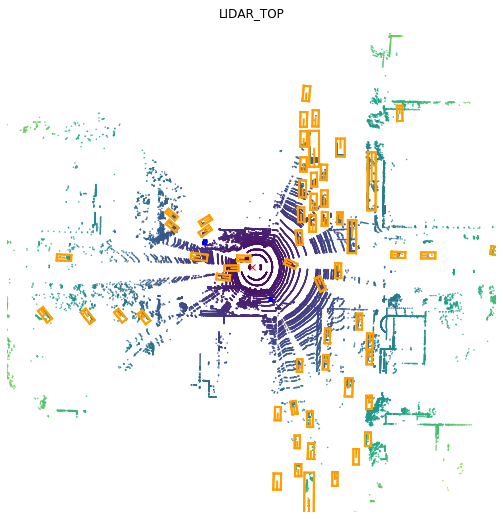

In [27]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(sample_token)

### Create artifacts to train data

In [63]:
import os
from datetime import datetime
from functools import partial
from multiprocessing import Pool


In [24]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

NUM_WORKERS = os.cpu_count() * 3

# "bev" stands for birds eye view
# test_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_test_data")
test_data_folder = '/media/juancr/Data/Lyft/artifacts_test'


In [52]:
NUM_WORKERS = os.cpu_count() * 3

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]


In [55]:
## Get train_df
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [56]:
df.head()

,host,scene_name,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230485630199365106-123048565...,2019-01-02 17:33:50.301987,473093b48a7cb78d05e36245fd2dbd12d66ded7dab1ecb...,c7f7de87ec90c8993d4e7d5463208d2aa9f5ecde671960...
1,host-a007,host-a007-lidar0-1230672860198383106-123067288...,2019-01-04 21:34:20.301189,c62b89d6ae60528c00b8a520bfa16799147f5c2dccbe1e...,07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c...
2,host-a007,host-a007-lidar0-1230936221299185986-123093624...,2019-01-07 22:43:41.402021,694dc7b4629151745d3e1b228b1d6653b0fc1ded12aa8d...,83ce1da2c4b37ca88a102928f01512acf8f55ac7207d04...
3,host-a007,host-a007-lidar0-1231093036199514746-123109306...,2019-01-09 18:17:16.302257,8ed3a2f8cf6e01e0d2c0df7db77839f468ed2aa48b6511...,dddda3940f002b0fa6c495a5ad6d5c4a4c8253aa5ed189...
4,host-a009,host-a009-lidar0-1231200854198312986-123120087...,2019-01-11 00:14:14.301261,a05a48966fbc46666be116a79222374c6c79e6fa930c2f...,8990abea0a146b047a04bc6ed303b16cb1c62cca49bf58...


###  Execute when there are no data in artifacts_train folder

In [58]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")

140 40 train/validation split scene counts


In [64]:
train_data_folder = "./bev_train_data"
validation_data_folder = "./bev_validation_data"

for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()
    del pool

Preparing data into ./bev_train_data using 36 workers


Failed to load Lidar Pointcloud for 9cb04b1a4d476fd0782431764c7b55e91c6dbcbc6197c3dab3e044f13d058011: cannot reshape array of size 265728 into shape (5):

Preparing data into ./bev_validation_data using 36 workers


In [26]:
def prepare_testing_data_for_scene(sample_token, output_folder=test_data_folder,
                                   bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset,
                                   box_scale=box_scale):
    """
    Given a sample token (in a scene), output rasterized input volumes in birds-eye-view perspective.

    """
    
#     while sample_token:
        
    sample = level5data.get("sample", sample_token)
    

    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    
    

    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
    


    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)
    

    car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                        inverse=False)
    
    
    lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
    
    lidar_pointcloud.transform(car_from_sensor)

    bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
    bev = normalize_voxel_intensities(bev)

    bev_im = np.round(bev*255).astype(np.uint8)
    #print(output_folder)
    cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)

In [17]:
from tqdm import tqdm, tqdm_notebook

In [77]:
sample_data_train.sample_token.unique()[0]

'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d'

###  Execute when there are no data in artifacts_test folder

In [97]:
len(sample_data_train.sample_token.unique())

22680

In [99]:
for token in tqdm_notebook(sample_data_train.sample_token.unique()[16718:]):
    prepare_testing_data_for_scene(token)

### Load Data

In [4]:
import glob
from tqdm import tqdm, tqdm_notebook

In [5]:
TRAIN_PATH_GLOB = "./bev_train_data/*_input.png"
TRAIN_TARGET_PATH_GLOB = "./bev_train_data/*_target.png"
train_fns = glob.glob(TRAIN_PATH_GLOB)
train_target_fns = glob.glob(TRAIN_TARGET_PATH_GLOB)

In [6]:
img_height,img_width = 336,336
img_chan = 3
X_train = np.zeros((len(train_fns), img_height, img_width, img_chan), dtype=np.int8) 

In [7]:
train_target_fns = glob.glob(TRAIN_TARGET_PATH_GLOB)
X_train_target = np.zeros((len(train_target_fns), img_height, img_width), dtype=np.int8) 

###  Read image files

In [8]:
from PIL import Image
import cv2

In [7]:
train_target_fns[0]

'./bev_train_data/0002feb94bcece2bd8b07da5237e0ee203cc3e84446607bcca1df51aecc34e15_target.png'

In [35]:
pic = Image.open(train_target_fns[0])

In [36]:
np.array(pic).shape

(336, 336)

In [123]:
X_train[0].shape

(336, 336, 3)

In [21]:
X_train[0][150]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int8)

In [9]:
for i in tqdm_notebook(range(0, len(train_fns))):
    X_train[i] += Image.open(train_fns[i])

In [10]:
for j in tqdm_notebook(range(0, len(train_target_fns))):
    X_train_target[j] += Image.open(train_target_fns[j])

###  Write model

In [15]:
import os 
from keras import applications
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD,Adam

In [10]:

base_model = applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(img_height,img_width,3))

/home/juancr/anaconda3/envs/lyft/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
num_classes = 9
tensor_output = img_height*img_width
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
prediction = Dense(tensor_output, activation='softmax')(x)
model = Model(inputs=base_model.input, output=prediction)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/juancr/anaconda3/envs/lyft/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [39]:

# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
X_train.shape

(17639, 336, 336, 3)

In [24]:
X_train_target.shape

(17639, 336, 336)

In [47]:
X_train_target_res = X_train_target.reshape((-1, img_height, img_width))

ValueError: cannot reshape array of size 1991372544 into shape (336,336)

In [21]:
X_train_res = X_train.reshape((-1, img_height, img_width, 1))

In [46]:


model.fit(x=X_train, y=X_train_target_res, epochs=10, batch_size=64)

ValueError: Error when checking target: expected dense_5 to have 2 dimensions, but got array with shape (17639, 336, 336)

###  Write second model

In [12]:
from keras.layers import BatchNormalization, Activation

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [13]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
input_img = Input((img_height, img_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 336, 336, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 336, 336, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 336, 336, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 336, 336, 16) 0           batch_normalization_19[0][0]     
______________

In [17]:
X_train_res = X_train.reshape((-1, img_height, img_width, 1))
          
X_train_target_res = X_train_target.reshape((-1, img_height, img_height, 1))

In [68]:
X_train_res.shape

(52917, 336, 336, 1)

In [69]:
X_train_target_res.shape

(17639, 336, 336, 1)

In [18]:
FILE_NAME = 'winner-float1.h5'
if os.path.isfile(FILE_NAME):
    print('exists the file: ' + FILE_NAME)
    
    model = load_model(FILE_NAME)
else:
    
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(FILE_NAME, verbose=1, save_best_only=True)
    model.fit(X_train_res[:17639], X_train_target_res, validation_split=0.1, 
              batch_size=20, epochs=150, callbacks=[earlystopper, checkpointer])

Train on 15875 samples, validate on 1764 samples
Epoch 1/150
15875/15875 [==============================] - 401s 25ms/step - loss: 0.1546 - acc: 0.9849 - val_loss: 0.0887 - val_acc: 0.9894

Epoch 00001: val_loss improved from inf to 0.08874, saving model to winner-float1.h5
Epoch 2/150
15875/15875 [==============================] - 386s 24ms/step - loss: 0.0885 - acc: 0.9887 - val_loss: 0.0825 - val_acc: 0.9894

Epoch 00002: val_loss improved from 0.08874 to 0.08248, saving model to winner-float1.h5
Epoch 3/150
15875/15875 [==============================] - 386s 24ms/step - loss: 0.0855 - acc: 0.9887 - val_loss: 0.0819 - val_acc: 0.9894

Epoch 00003: val_loss improved from 0.08248 to 0.08187, saving model to winner-float1.h5
Epoch 4/150
15875/15875 [==============================] - 386s 24ms/step - loss: 0.0844 - acc: 0.9887 - val_loss: 0.0805 - val_acc: 0.9894

Epoch 00004: val_loss improved from 0.08187 to 0.08051, saving model to winner-float1.h5
Epoch 5/150
15875/15875 [==========

In [22]:
sample_data_test = pd.read_json('/media/juancr/Data/Lyft/test_data/sample_data.json')

In [23]:
sample_data_test.head()

,fileformat,is_key_frame,height,timestamp,filename,token,ego_pose_token,sample_token,prev,next,calibrated_sensor_token,width
0,jpeg,True,1024.0,2019-02-08 19:23:28.717605000,images/host-a011_cam2_1233689008717605006.jpeg,1b7ad8ac352589c4a86f9a6cbef4f136a4272bd6291eae...,e170e300eb28df54eaf0ffc16659124aebd3d0df264e24...,2f7129731b7a7a81265deb5f8df44e937ea60824238a1b...,cba4c4e61f2b8824ed22e37e85cd3bf19e9f970eb4fb78...,7e83e9c889f6ef2b45da7223da3b4a201e87b1d88b9cab...,04afbdfff5bc7913179997e0a8e4067ca9eac5cf329001...,1224.0
1,bin,True,NaN,2019-02-11 23:17:58.301031250,lidar/host-a011_lidar1_1233962278301031366.bin,5468aea18ec7506b5660aab1d09a534d840eaa252b3545...,45ebc7b166fac45f97292939113bbef9b8cfd9cb267021...,311a858f719389a4fd914ccf6bb3b1294c10f95fbbe417...,7a7e5f25824c7db4a3e2ea5ca18eefa23bf2fc13e3549e...,548fd8ce4b103cf28bb2d8059716b05714b96f50919f65...,043947e092f2df7723186143caafad12b5f4ae51328ce0...,NaN
2,jpeg,True,1024.0,2019-02-11 21:55:58.850968000,images/host-a015_cam0_1233957358850968006.jpeg,59a7689c386ae985181f3b709c2ce3e67b666086be8142...,96f269f9d63e2827d883cebb6529dcfad8f44a59245bdf...,7bfdadbdae169b0dc4a9704de19654203d5658aa961e78...,37dca76ea52c5964eb4ebd8be96b09d6a461f03013a2c9...,758a1ca944111554b062a0df648c3d569df06ff8789ba6...,c6823615f781fb7fbc629fc6992a6dc15786fd3d613eaa...,1224.0
3,jpeg,True,864.0,2019-02-01 20:50:52.450948000,images/host-a004_cam6_1233089452450948006.jpeg,b87b3ea33a28bbd065fa7123dcc9ff71cac88f3b1d5754...,8d148e2defa6150444d41c1725e5e3a10b0763e04e883a...,85d428b83c90880a23aa634da1a821d0af6e1045046849...,4c291e1f5b4bb43f43b7e268be1efcef9b1c912903e336...,ad749dd7344f857720aaa9cc52b2714f942fd6fe5bc08d...,bb86c8ed87c60936572901c1d8159fcb6f9d46ec7e2ac2...,2048.0
4,jpeg,True,1024.0,2019-03-08 23:44:18.984485000,images/host-a011_cam4_1236123858984485006.jpeg,d1d674e496610b7c5d42ba46bc48d237b55c77627eec9a...,e6ed33615480148fb928303fda1a38d8074084a09a6b23...,24a7090eca5d85a680bd975ad30ad43bd2a598227fa697...,644f1c0b49b00c78e4ac38f138000e069a6c470fc92c01...,e04d87e2d13b65d62e3c8105004f447cf86164906a2a87...,1752d13cc27a84424457a0ec095f8b501342ae6b96dac7...,1224.0


In [28]:
level5data = LyftDataset(data_path='.', json_path='/media/juancr/Data/Lyft/test_data', verbose=True)

JSON file instance.json missing, using empty list
JSON file sample_annotation.json missing, using empty list
9 category,
17 attribute,
4 visibility,
0 instance,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
0 sample_annotation,
1 map,
Done loading in 3.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.7 seconds.


In [30]:
# Create soft links

!ln -s /media/juancr/Data/Lyft/test_images images
!ln -s /media/juancr/Data/Lyft/test_maps maps
!ln -s /media/juancr/Data/Lyft/test_lidar lidar

In [34]:
for token in tqdm_notebook(sample_data_test.sample_token.unique()):
    prepare_testing_data_for_scene(token)

In [35]:
TEST_PATH_GLOB = "./artifacts_test/*_input.png"
test_fns = glob.glob(TEST_PATH_GLOB)

In [36]:
img_height,img_width = 336,336
img_chan = 3
X_test = np.zeros((len(test_fns), img_height, img_width, img_chan), dtype=np.int8) 

In [ ]:
for i in tqdm_notebook(range(0, len(test_fns))):
    X_test[i] += Image.open(test_fns[i])

In [ ]:
model.predict()